# Integrating Product Design and Supply Chain Design

## Import Packages

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import pandas as pd
from pandas import DataFrame, read_csv

import sys
sys.path.append('../')
import saedfsc

## Display Graph

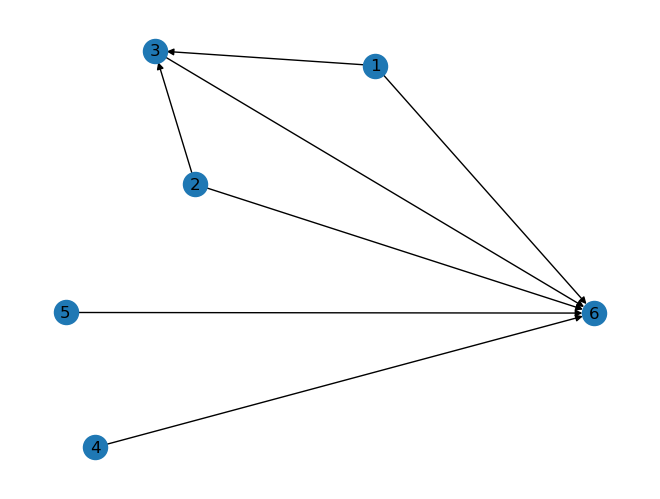

In [12]:
G = nx.DiGraph()

numNodes = 6
numOptions = 2

np.random.seed(0)
stageCostsList = np.random.randint(1, 10, numNodes)
processTimesList = np.random.randint(1, 10, numNodes)
maxServiceTimeOutList = 20*np.ones(numNodes)
maxServiceTimeOutList[numNodes-1] = 0

for i in range(numNodes):
    G.add_node(i+1, process_time=processTimesList[i], 
               max_service_time_out=maxServiceTimeOutList[i],
               stage_cost=stageCostsList[i])

maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')

# Add edges between nodes to create the tree
G.add_edge(1, 3)
G.add_edge(2, 3)
G.add_edge(1, 6)
G.add_edge(2, 6)
G.add_edge(3, 6)
G.add_edge(4, 6)
G.add_edge(5, 6)

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

## Options for Each Component

In [13]:
optionsInfo = {}
for i in range(numNodes):
    for k in range(numOptions):
        optionsInfo[i+1,k] = {'cost' : np.random.randint(1, 10), 'time' : np.random.randint(1, 10)}

flattened_optionsInfo = {(i,k): values for (i,k), values in optionsInfo.items()}

df = pd.DataFrame.from_dict(flattened_optionsInfo, orient='index')

df.reset_index(inplace=True)
df.columns = ['Node', 'Option', 'Cost', 'Time']
df

,Node,Option,Cost,Time
0,1,0,3,4
1,1,1,9,2
2,2,0,4,4
3,2,1,4,8
4,3,0,1,2
5,3,1,1,5
6,4,0,8,4
7,4,1,3,8
8,5,0,3,1
9,5,1,1,5


## Customers

In [14]:
customerTypes = list(range(2))
meanDemandForCustomerType = {c : np.random.randint(1, 20) for c in customerTypes}
stDevDemandForCustomerType = {c : 3 for c in customerTypes}
saedfsc.customers

,Name,Quantity,PriceFocus,PartworthUtilityWeights,PerformanceUtilityWeights
0,CustomerType1,469,0.391040,"[0.91450978,0.08733943,0.51950344,0.55561313,0...","[0.34496792,0.6898727 ,0.13100207,0.50656613,0..."
1,CustomerType2,929,0.951341,"[0.66601538,0.54644132,0.24889524,0.86383297,0...","[0.46336316,0.47837937,0.80161025,0.20513706,0..."
2,CustomerType3,294,0.740209,"[0.52786049,0.73410731,0.85361372,0.83415508,0...","[0.92694124,0.48651615,0.78058322,0.45806116,0..."
3,CustomerType4,834,0.608726,"[0.30815853,0.44577241,0.59348252,0.60900538,0...","[0.45334148,0.17085646,0.67141338,0.78225234,0..."
4,CustomerType5,733,0.565038,"[0.7610932 ,0.05656771,0.61822428,0.8374061 ,0...","[0.64583732,0.09631073,0.23214996,0.88206262,0..."
5,CustomerType6,35,0.254575,"[0.5931458 ,0.67793322,0.22446516,0.4948187 ,0...","[0.57868043,0.07927113,0.05214455,0.78084477,0..."
6,CustomerType7,239,0.362928,"[0.66483611,0.90905972,0.18731687,0.66342118,0...","[0.54702712,0.05151569,0.09804964,0.04074776,0..."
7,CustomerType8,564,0.770436,"[0.76932255,0.36910923,0.89955738,0.1623181 ,0...","[0.56254937,0.13950323,0.18176402,0.34446781,0..."
8,CustomerType9,927,0.599208,"[0.51947281,0.1023688 ,0.59192487,0.60865134,0...","[0.53924253,0.90808112,0.34176956,0.47190584,0..."
9,CustomerType10,366,0.452926,"[0.09527526,0.13840712,0.67149965,0.23045829,0...","[0.09699416,0.73592342,0.92129521,0.89635862,0..."


## Objectives (Performance Metrics)

In [ ]:
objectiveIndices = list(range(11)) # I think there are 11 indices in the objective function but I could be wrong

## Define Parameters and Sets

In [ ]:
meanDemand = 5
stdDevDemand = 3
holdingCostRate = 1
safetyFactor = 2
betaMult = 5
numComponentsRequired = 3
price = 200

holdCostCoef = holdingCostRate*safetyFactor

procureNodes = [1,2,4,5]
assemblyNodes = [3]
finalNodes = [6]
nonProcureNodes = [3,6]

## The Model in Gurobipy

In [ ]:
m = gp.Model("safety stock")

stdDevDemandVar = m.addVar(name="stdDevDemand")
meanDemandVar = m.addVar(name="meanDemand")
marketShare = m.addVars(customerTypes, ub = 1, name="marketShare")
objValVars = m.addVars(objectiveIndices, ub = 1, 
                    name="objValVar") #normalized to [0,1], where 1 is best

componentSelect = m.addVars(procureNodes, vtype=GRB.BINARY, 
                            name="nodeSelect")
arcSelect = m.addVars(G.edges(), vtype=GRB.BINARY, name="arcSelect")
optionSelect = m.addVars(optionsInfo.keys(), vtype=GRB.BINARY, 
                            name="optionSelect")
stageTime = m.addVars(G.nodes(), vtype=GRB.INTEGER, 
                    name="stageTime")
stageCost = m.addVars(G.nodes(), vtype=GRB.INTEGER, 
                    name="stageCost")
sIn = m.addVars(G.nodes(), vtype=GRB.INTEGER, name="sIn")
sOut = m.addVars(G.nodes(), ub = maxServiceTimeOut, vtype=GRB.INTEGER, 
                 name="sOut")
netTime = m.addVars(G.nodes(), ub = sum(processTimesList), vtype=GRB.INTEGER, 
                    name="netTime")
sqrtNetTime = m.addVars(G.nodes(), vtype=GRB.INTEGER, name="sqRootnetTime")
cumCostVar = m.addVars(G.nodes(), name="cumCost")

stdDevDemandTimesCumCostVar = m.addVars(G.nodes(), 
                                        name="stdDevDemandTimesCumCost")
meanDemandTimesStageTimeVar = m.addVars(G.nodes(), 
                                        name="meanDemandTimesStageTime")

# convenience functions for flow balance
def outFlowSum(i):
    return qsum(arcSelect[i,j] for j in G.successors(i))

def inFlowSum(i): 
    return qsum(arcSelect[j,i] for j in G.predecessors(i))

m.addConstrs((stageCost[i] == qsum(optionsInfo[i,k]['cost']*optionSelect[i,k] 
                                   for k in range(numOptions)) 
              for i in G.nodes()), 
              name="StageCostCalc")
m.addConstrs((stageTime[i] == qsum(optionsInfo[i,k]['time']*optionSelect[i,k] 
                                   for k in range(numOptions)) 
              for i in G.nodes()), 
              name="StageTimeCalc")
m.addConstrs((cumCostVar[j] == stageCost[j] + qsum(cumCostVar[i]*arcSelect[i,j] 
                                                    for i in G.predecessors(j)) 
                                                    for j in G.nodes()), 
             name="calcCumCost")
m.addConstrs((sIn[j] >= sOut[i]*arcSelect[i,j] for i,j in G.edges()), 
             name="sInGreater")
m.addConstrs((optionSelect.sum(i,'*') == componentSelect[i] for i in procureNodes), 
             "select1-component")
m.addConstrs((optionSelect.sum(i,'*') == 1 for i in nonProcureNodes), 
             "select1-other")
m.addConstrs((inFlowSum(i) == G.in_degree(i)*outFlowSum(i) for i in assemblyNodes), 
             name="netFlow")
m.addConstrs((qsum(arcSelect[i,j] for j in G.successors(i)) == componentSelect[i] 
              for i in procureNodes), 
             name="sumOutFlow")
m.addConstrs((arcSelect[i,j] <= componentSelect[i] 
              for i,j in G.edges() if i in procureNodes), 
              "useArcIfNode")
m.addConstrs((sIn[i] == 0 for i in procureNodes), 
             name="procureNodesInTime")
m.addConstrs((netTime[i] == sIn[i] + stageTime[i] - sOut[i] 
              for i in G.nodes()), 
              name="NetTimeCalc")
m.addConstrs((netTime[i] == sqrtNetTime[i]*sqrtNetTime[i] 
              for i in G.nodes()), 
             name="SqRootNetTimeCalc")
m.addConstrs((stdDevDemandTimesCumCostVar[i] == stdDevDemandVar*cumCostVar[i] 
              for i in G.nodes()), 
             name="stdDevDemandTimesCumCostVar")
m.addConstrs((meanDemandTimesStageTimeVar[i] == meanDemandVar*stageTime[i] 
              for i in G.nodes()), 
             name="meanDemandTimesStageTimeVar")
m.addConstr(meanDemandVar == qsum(meanDemandForCustomerType[c]*marketShare[c] for c in customerTypes), 
            name="meanDemandVar")
m.addConstr(stdDevDemandVar**2 <= qsum(stDevDemandForCustomerType[c]**2*marketShare[c]**2 
                                       for c in customerTypes), 
            name="stdDevDemandVar")
m.addConstrs((marketShare[c]**2 <= qsum(customerWts[c,o]*objValVars[o] for o in objectiveIndices) 
              for c in customerTypes), 
             name="marketShareCalc")

# placeholder constraints to make example work
m.addConstr(qsum(componentSelect[i] for i in procureNodes) == numComponentsRequired, 
             name="componentsRequired")

m.setObjective(price*meanDemandVar 
               - qsum(holdCostCoef*stdDevDemandTimesCumCostVar[i]*sqrtNetTime[i] 
                    + holdingCostRate*(cumCostVar[i] - stageCost[i]/2)*meanDemandTimesStageTimeVar[i]
                    + betaMult*stageCost[i]*meanDemandVar
                                            for i in G.nodes()), 
                                                GRB.MAXIMIZE); # maximize expected profit

In [ ]:
m.write("model.lp")

In [ ]:
m.Params.LogToConsole = 0
m.optimize()
print("Profit: $", format(m.ObjVal, ",.2f"))

print("Revenue: $", format(price*meanDemandVar.X, ",.2f"))

sInVals = [sIn[i].X for i in  G.nodes()]
sOutVals = [sOut[i].X for i in  G.nodes()]
netTimeVals = [netTime[i].X for i in  G.nodes()]
holdingCostVals = [holdCostCoef*(stdDevDemandTimesCumCostVar[i].X)*sqrtNetTime[i].X for i in  G.nodes()]
pipelineCostVals = [holdingCostRate*(cumCostVar[i].X - stageCost[i].X/2)*stageTime[i].X*meanDemand 
                    for i in  G.nodes()]
cogsVals = [betaMult*stageCost[i].X*meanDemand for i in  G.nodes()]

df1 = pd.DataFrame({
    'Node': G.nodes(),
    'process time': [stageTime[i].X for i in  G.nodes()],
    'stage cost': [stageCost[i].X for i in  G.nodes()],
    'cum cost': [cumCostVar[i].X for i in  G.nodes()],
    'sIn': sInVals,
    'sOut': sOutVals,
    'Max time' : [maxServiceTimeOut[i] for i in  G.nodes()],
    'netTime': netTimeVals,
    'holding cost' : holdingCostVals,
    'pipeline cost' : pipelineCostVals,
    'COGS' : cogsVals
})

df2 = pd.DataFrame({
    'Arc': G.edges(),
    'Selected': [arcSelect[i,j].X for i,j in  G.edges()]
})

df3 = pd.DataFrame({
    'Component': componentSelect.keys(),
    'Selected': [componentSelect[i].X for i in componentSelect.keys()]
})

df4 = pd.DataFrame({
    'Customer': customerTypes,
    'Qty': [meanDemandForCustomerType[c] for c in customerTypes],
    'Market Share': [marketShare[c].X for c in customerTypes]
})

print(df2)
print(df3)
print(df4)
df1

Profit: $ 1,649.00
Revenue: $ 6,800.00
      Arc  Selected
0  (1, 3)       0.0
1  (1, 6)       1.0
2  (2, 3)       0.0
3  (2, 6)       0.0
4  (3, 6)       0.0
5  (4, 6)       1.0
6  (5, 6)       1.0
   Component  Selected
0          1       1.0
1          2       0.0
2          4       1.0
3          5       1.0
   Customer  Qty  Market Share
0         0   18           1.0
1         1   16           1.0


,Node,process time,stage cost,cum cost,sIn,sOut,Max time,netTime,holding cost,pipeline cost,COGS
0,1,4.0,3.0,3.0,0.0,4.0,20.0,0.0,0.0,30.0,75.0
1,2,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
2,3,2.0,1.0,1.0,8.0,10.0,20.0,0.0,0.0,5.0,25.0
3,4,8.0,3.0,3.0,0.0,8.0,20.0,0.0,0.0,60.0,75.0
4,5,5.0,1.0,1.0,0.0,5.0,20.0,0.0,0.0,12.5,25.0
5,6,6.0,6.0,13.0,10.0,0.0,0.0,16.0,0.0,300.0,150.0


In [ ]:
#!cat model.lp